
Crack segmentation with U-Net

I have used the following methods.

* Dice coefficient implementation,
* Custom layers for encoding and decoding
* Custom callback class  that used predicting a sample from the test dataset during training


## Result
In the 250th epoch
* loss: 0.0066 - dice_coef_loss: 0.1519 - dice_coef: 0.8481


## References
1. [Dataset] Sabouri, Mohammadreza; Sepidbar, Alireza (2023), “SUT-Crack”, Mendeley Data, V5, doi: 10.17632/gsbmknrhkv.5
2. Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation https://doi.org/10.48550/ARXIV.1505.04597

In [181]:
# Importing dependencies

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Layer, concatenate , BatchNormalization

from sklearn.model_selection import train_test_split

SEED = 10
BATCH_SIZE = 8
IMG_SIZE = 512, 512

(-0.5, 3023.5, 4031.5, -0.5)

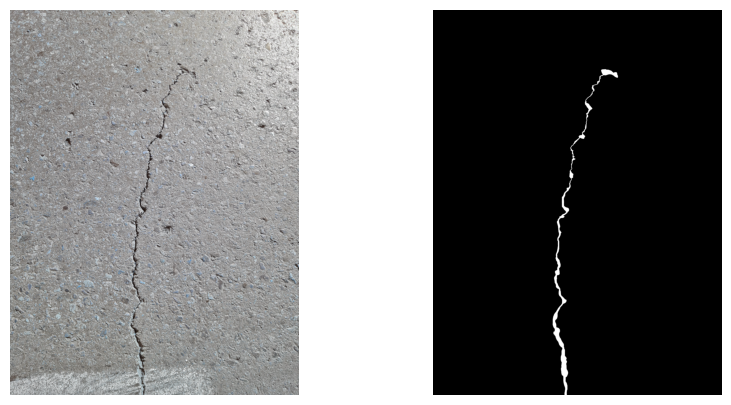

In [199]:
# An example from the dataset

img = cv2.imread('/content/1-Segmentation/Original_Image/35.jpg')
mask = cv2.imread('/content/1-Segmentation/GroundTruth/35.png')

fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0].imshow(img)
axs[0].axis('off')

axs[1].imshow(mask)
axs[1].axis('off')

In [182]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in tqdm(images, desc = 'images' ):
    #for i in images:

        full_path.append(os.path.join(path, i))

    return full_path


original_images = create_images_list('/content/1-Segmentation/Original_Image')
mask_images = create_images_list('/content/1-Segmentation/GroundTruth')


data = pd.DataFrame({ 'image': original_images, 'mask' : mask_images })


train_df = data[15:]
test_df = data[:15]

images:   0%|          | 0/90 [00:00<?, ?it/s]

images:   0%|          | 0/90 [00:00<?, ?it/s]

In [70]:
print("train images: ", X_train.shape[0])
print("test images: ", X_test.shape[0])

train images:  72
test images:  18


In [183]:
def img_preprocessing(image, mask):
  img = tf.io.read_file(image)
  img = tf.io.decode_jpeg(img, channels = 3)
  img = tf.image.resize(img, size = (IMG_SIZE))
  img = tf.cast(img, tf.float32) / 255.0

  mask = tf.io.read_file(mask)
  mask = tf.io.decode_png(mask, channels = 1)
  mask = tf.image.resize(mask, size = (IMG_SIZE))
  mask = tf.cast(mask, tf.float32) / 255.0
  mask = tf.image.rot90(mask)

  return img, mask


def img_augmentation(image, mask):
    img = tf.image.random_brightness(image, 0.2)
    img = tf.image.random_contrast(img, 0.2, 0.3)

    return img, mask


In [184]:
# Creating dataset loaders

train_loader = tf.data.Dataset.from_tensor_slices((train_df['image'], train_df['mask']))
train_dataset = (train_loader
                 .map(img_preprocessing)
                 .batch(BATCH_SIZE)
                 .prefetch(BATCH_SIZE))


test_loader = tf.data.Dataset.from_tensor_slices((test_df['image'], test_df['mask']))
test_dataset = (test_loader
                .map(img_preprocessing)
                .batch(BATCH_SIZE)
                .prefetch(BATCH_SIZE))


In [90]:
# Encoding block for U-net architecture

class EncoderBlock(Layer):
    def __init__(self, filters, kernel_size, rate, pooling = True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.rate = rate
        self.pooling = pooling

        self.conv1 = Conv2D(filters, kernel_size, activation = 'relu', strides = 1,  padding = 'same' ,kernel_initializer = 'he_normal')
        self.conv2 = Conv2D(filters, kernel_size, activation= 'relu', strides = 1, padding = 'same', kernel_initializer = 'he_normal')
        self.drop = Dropout(rate)
        self.pool = MaxPooling2D()


    def call(self, inputs):
        X = self.conv1(inputs)
        X = self.drop(X)
        X = self.conv2(X)
        if self.pooling:
            P = self.pool(X)
            return P,X
        else:
            return X


    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "rate" : self.rate,
            "pooling" : self.pooling }


class DecoderBlock(Layer):
    def __init__(self, filters, kernel_size, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.rate = rate

        self.up = UpSampling2D()
        self.nn = EncoderBlock(filters, kernel_size, rate, pooling = False)


    def call(self, inputs):
        inputs, skip_inputs = inputs
        X = self.up(inputs)
        C = concatenate([X, skip_inputs ])
        X = self.nn(C)
        return X


    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "rate" : self.rate,
            "pooling" : self.pooling }

In [ ]:
samples = list(train_dataset.take(-1))

idxs = np.random.permutation(train_df.shape[0])[0]
batch_idx = idxs // BATCH_SIZE
image_idx = idxs-batch_idx * BATCH_SIZE
idx = idxs

image = samples[batch_idx][0][image_idx]
mask = samples[batch_idx][1][image_idx]


fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0].imshow(image)

axs[1].imshow(mask)

TensorShape([512, 512, 3])

In [185]:
# Custom callback for predicting one sample from test dataset during training each 50 epochs

class PredictDuringTraining(Callback):
    def on_epoch_end(self, epochs, logs = None ):

        if (epochs + 1) % 10 == 0:
            samples = list(test_dataset.take(-1))

            idxs = np.random.permutation(test_df.shape[0])[0]
            batch_idx = idxs // BATCH_SIZE
            image_idx = idxs-batch_idx * BATCH_SIZE
            idx = idxs

            image = samples[batch_idx][0][image_idx]
            mask = samples[batch_idx][1][image_idx]

            pred_mask = self.model.predict(image[np.newaxis,...], verbose = 0)
            pred_ = np.squeeze(pred_mask)
            threshold  = 0.5
            bitmap_pred = (pred_ > threshold).astype(np.uint8)

            fig, axs = plt.subplots(1,3, figsize = (5,2) ,dpi = 120)
            fig.suptitle( 'epoch no :' + str(epochs + 1)  + ' ,images no :' + str(idx) + '\n (github.com/john-fante, kaggle.com/banddaniel)', color='red', fontsize = 8 )

            axs[0].imshow(image , cmap = 'gray')
            axs[0].axis('off')
            axs[0].set_title('original image', fontsize = 6)

            axs[1].imshow(mask, cmap = 'gray')
            axs[1].axis('off')
            axs[1].set_title('original mask', fontsize = 6)

            axs[2].imshow( bitmap_pred, cmap = 'gray')
            axs[2].axis('off')
            axs[2].set_title('predict mask', fontsize = 6)

            plt.tight_layout()
            plt.show()
        else:
            pass

In [174]:
# Creating Dice and Jaccard metrics

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [188]:
inp = Input(shape = (*IMG_SIZE, 3))

p1,c1 = EncoderBlock(32, 2, 0.1, name = 'ENCODER_1')(inp)
p2,c2 = EncoderBlock(64, 2, 0.1, name =  'ENCODER_2')(p1)
p3,c3 = EncoderBlock(128, 2, 0.2, name =  'ENCODER_3')(p2)
p4,c4 = EncoderBlock(256, 2, 0.2,  name = 'ENCODER_4')(p3)

encoding = EncoderBlock(512 , 2, 0.3, pooling = False ,name = 'ENCODING')(p4)

d1 = DecoderBlock(256, 2, 0.2 ,name = 'DECODER_1' )([encoding, c4])
d2 = DecoderBlock(128 ,2, 0.2 ,name = 'DECODER_2' )([d1, c3])
d3 = DecoderBlock(64 ,2, 0.1 ,name = 'DECODER_3' )([d2, c2])
d4 = DecoderBlock(32 ,2, 0.1 ,name = 'DECODER_4' )([d3, c1])

out = Conv2D(1, 1 ,activation ='sigmoid', padding = 'same')(d4)

model = Model(inputs = inp, outputs = out)
#model.summary()

model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy' , metrics = [dice_coef_loss, dice_coef])
my_callbacks = [PredictDuringTraining()]

Epoch 1/250
 6/10 [=================>............] - ETA: 3s - loss: 0.6064 - dice_coef_loss: 0.9818 - dice_coef: 0.0182

10/10 [==============================] - 20s 776ms/step - loss: 0.4110 - dice_coef_loss: 0.9828 - dice_coef: 0.0172
Epoch 2/250
10/10 [==============================] - 13s 1s/step - loss: 0.0709 - dice_coef_loss: 0.9743 - dice_coef: 0.0257
Epoch 3/250
10/10 [==============================] - 16s 2s/step - loss: 0.0691 - dice_coef_loss: 0.9699 - dice_coef: 0.0301
Epoch 4/250
10/10 [==============================] - 13s 1s/step - loss: 0.0682 - dice_coef_loss: 0.9681 - dice_coef: 0.0319
Epoch 5/250
10/10 [==============================] - 11s 1s/step - loss: 0.0645 - dice_coef_loss: 0.9602 - dice_coef: 0.0398
Epoch 6/250
10/10 [==============================] - 13s 1s/step - loss: 0.0610 - dice_coef_loss: 0.9453 - dice_coef: 0.0547
Epoch 7/250
10/10 [==============================] - 12s 1s/step - loss: 0.0584 - dice_coef_loss: 0.9236 - dice_coef: 0.0764
Epoch 8/250
10/10 [==============================] - 13s 1s/step - loss: 0.0566 - dice_coef_loss: 0.8965 - dice_coef: 0.1035
Epoch 9/2

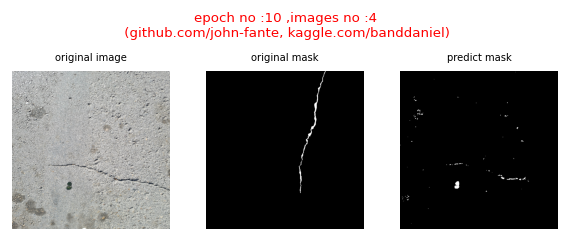

10/10 [==============================] - 15s 1s/step - loss: 0.0498 - dice_coef_loss: 0.8130 - dice_coef: 0.1870
Epoch 11/250
10/10 [==============================] - 12s 1s/step - loss: 0.0495 - dice_coef_loss: 0.7975 - dice_coef: 0.2025
Epoch 12/250
10/10 [==============================] - 13s 1s/step - loss: 0.0518 - dice_coef_loss: 0.8179 - dice_coef: 0.1821
Epoch 13/250
10/10 [==============================] - 12s 1s/step - loss: 0.0490 - dice_coef_loss: 0.7834 - dice_coef: 0.2166
Epoch 14/250
10/10 [==============================] - 13s 1s/step - loss: 0.0508 - dice_coef_loss: 0.8024 - dice_coef: 0.1976
Epoch 15/250
10/10 [==============================] - 12s 1s/step - loss: 0.0479 - dice_coef_loss: 0.7748 - dice_coef: 0.2252
Epoch 16/250
10/10 [==============================] - 13s 1s/step - loss: 0.0461 - dice_coef_loss: 0.7377 - dice_coef: 0.2623
Epoch 17/250
10/10 [==============================] - 13s 1s/step - loss: 0.0459 - dice_coef_loss: 0.7524 - dice_coef: 0.2476
Epoch

<Figure size 640x480 with 0 Axes>

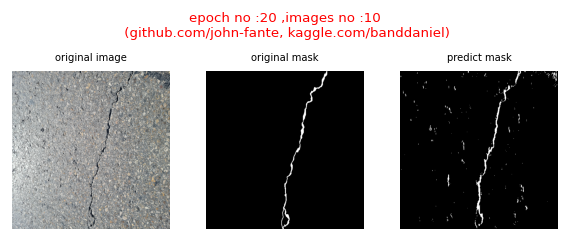

10/10 [==============================] - 15s 1s/step - loss: 0.0428 - dice_coef_loss: 0.7046 - dice_coef: 0.2954
Epoch 21/250
10/10 [==============================] - 13s 1s/step - loss: 0.0401 - dice_coef_loss: 0.6575 - dice_coef: 0.3425
Epoch 22/250
10/10 [==============================] - 13s 1s/step - loss: 0.0405 - dice_coef_loss: 0.6829 - dice_coef: 0.3171
Epoch 23/250
10/10 [==============================] - 11s 1s/step - loss: 0.0390 - dice_coef_loss: 0.6464 - dice_coef: 0.3536
Epoch 24/250
10/10 [==============================] - 12s 1s/step - loss: 0.0398 - dice_coef_loss: 0.6801 - dice_coef: 0.3199
Epoch 25/250
10/10 [==============================] - 13s 1s/step - loss: 0.0385 - dice_coef_loss: 0.6438 - dice_coef: 0.3562
Epoch 26/250
10/10 [==============================] - 11s 1s/step - loss: 0.0394 - dice_coef_loss: 0.6586 - dice_coef: 0.3414
Epoch 27/250
10/10 [==============================] - 13s 1s/step - loss: 0.0390 - dice_coef_loss: 0.6647 - dice_coef: 0.3353
Epoch

<Figure size 640x480 with 0 Axes>

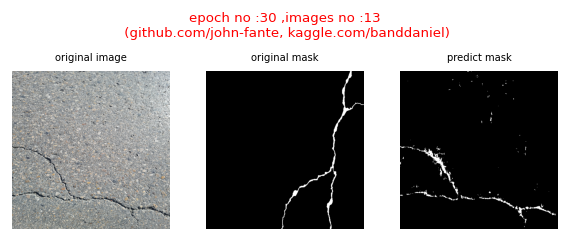

10/10 [==============================] - 16s 2s/step - loss: 0.0356 - dice_coef_loss: 0.6026 - dice_coef: 0.3974
Epoch 31/250
10/10 [==============================] - 12s 1s/step - loss: 0.0346 - dice_coef_loss: 0.5999 - dice_coef: 0.4001
Epoch 32/250
10/10 [==============================] - 13s 1s/step - loss: 0.0338 - dice_coef_loss: 0.5871 - dice_coef: 0.4129
Epoch 33/250
10/10 [==============================] - 13s 1s/step - loss: 0.0341 - dice_coef_loss: 0.5792 - dice_coef: 0.4208
Epoch 34/250
10/10 [==============================] - 13s 1s/step - loss: 0.0347 - dice_coef_loss: 0.5905 - dice_coef: 0.4095
Epoch 35/250
10/10 [==============================] - 13s 1s/step - loss: 0.0354 - dice_coef_loss: 0.5983 - dice_coef: 0.4017
Epoch 36/250
10/10 [==============================] - 13s 1s/step - loss: 0.0365 - dice_coef_loss: 0.6067 - dice_coef: 0.3933
Epoch 37/250
10/10 [==============================] - 12s 1s/step - loss: 0.0364 - dice_coef_loss: 0.6185 - dice_coef: 0.3815
Epoch

<Figure size 640x480 with 0 Axes>

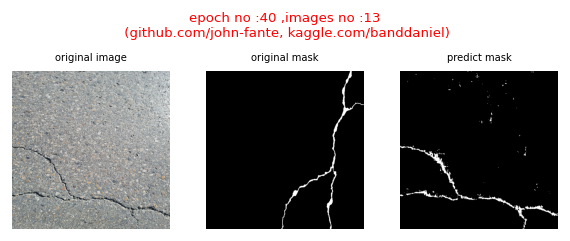

10/10 [==============================] - 16s 2s/step - loss: 0.0368 - dice_coef_loss: 0.6218 - dice_coef: 0.3782
Epoch 41/250
10/10 [==============================] - 14s 1s/step - loss: 0.0337 - dice_coef_loss: 0.5793 - dice_coef: 0.4207
Epoch 42/250
10/10 [==============================] - 13s 1s/step - loss: 0.0343 - dice_coef_loss: 0.5777 - dice_coef: 0.4223
Epoch 43/250
10/10 [==============================] - 13s 1s/step - loss: 0.0335 - dice_coef_loss: 0.5910 - dice_coef: 0.4090
Epoch 44/250
10/10 [==============================] - 13s 1s/step - loss: 0.0324 - dice_coef_loss: 0.5625 - dice_coef: 0.4375
Epoch 45/250
10/10 [==============================] - 13s 1s/step - loss: 0.0326 - dice_coef_loss: 0.5737 - dice_coef: 0.4263
Epoch 46/250
10/10 [==============================] - 12s 1s/step - loss: 0.0313 - dice_coef_loss: 0.5564 - dice_coef: 0.4436
Epoch 47/250
10/10 [==============================] - 13s 1s/step - loss: 0.0314 - dice_coef_loss: 0.5384 - dice_coef: 0.4616
Epoch

<Figure size 640x480 with 0 Axes>

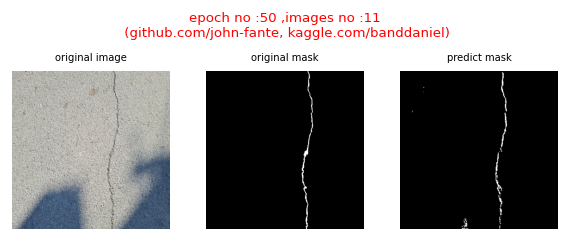

10/10 [==============================] - 15s 1s/step - loss: 0.0294 - dice_coef_loss: 0.5228 - dice_coef: 0.4772
Epoch 51/250
10/10 [==============================] - 13s 1s/step - loss: 0.0297 - dice_coef_loss: 0.5282 - dice_coef: 0.4718
Epoch 52/250
10/10 [==============================] - 14s 1s/step - loss: 0.0294 - dice_coef_loss: 0.5303 - dice_coef: 0.4697
Epoch 53/250
10/10 [==============================] - 12s 1s/step - loss: 0.0303 - dice_coef_loss: 0.5203 - dice_coef: 0.4797
Epoch 54/250
10/10 [==============================] - 12s 1s/step - loss: 0.0295 - dice_coef_loss: 0.5425 - dice_coef: 0.4575
Epoch 55/250
10/10 [==============================] - 15s 1s/step - loss: 0.0302 - dice_coef_loss: 0.5064 - dice_coef: 0.4936
Epoch 56/250
10/10 [==============================] - 12s 1s/step - loss: 0.0302 - dice_coef_loss: 0.5604 - dice_coef: 0.4396
Epoch 57/250
10/10 [==============================] - 12s 1s/step - loss: 0.0297 - dice_coef_loss: 0.5097 - dice_coef: 0.4903
Epoch

<Figure size 640x480 with 0 Axes>

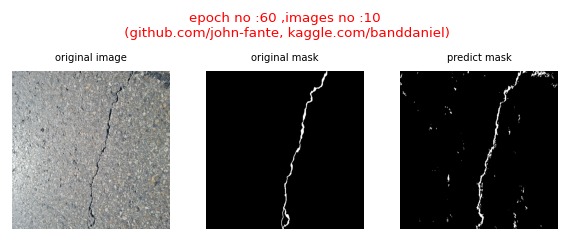

10/10 [==============================] - 15s 1s/step - loss: 0.0294 - dice_coef_loss: 0.4995 - dice_coef: 0.5005
Epoch 61/250
10/10 [==============================] - 15s 1s/step - loss: 0.0284 - dice_coef_loss: 0.5316 - dice_coef: 0.4684
Epoch 62/250
10/10 [==============================] - 12s 1s/step - loss: 0.0275 - dice_coef_loss: 0.4888 - dice_coef: 0.5112
Epoch 63/250
10/10 [==============================] - 15s 1s/step - loss: 0.0269 - dice_coef_loss: 0.4889 - dice_coef: 0.5111
Epoch 64/250
10/10 [==============================] - 13s 1s/step - loss: 0.0267 - dice_coef_loss: 0.4861 - dice_coef: 0.5139
Epoch 65/250
10/10 [==============================] - 14s 1s/step - loss: 0.0258 - dice_coef_loss: 0.4718 - dice_coef: 0.5282
Epoch 66/250
10/10 [==============================] - 12s 1s/step - loss: 0.0255 - dice_coef_loss: 0.4640 - dice_coef: 0.5360
Epoch 67/250
10/10 [==============================] - 13s 1s/step - loss: 0.0253 - dice_coef_loss: 0.4609 - dice_coef: 0.5391
Epoch

<Figure size 640x480 with 0 Axes>

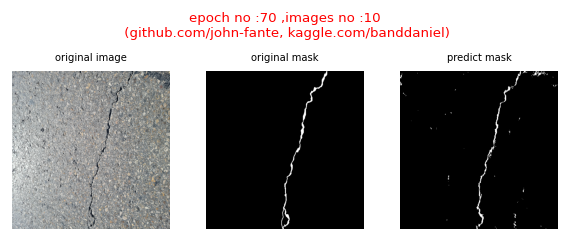

10/10 [==============================] - 14s 1s/step - loss: 0.0256 - dice_coef_loss: 0.4609 - dice_coef: 0.5391
Epoch 71/250
10/10 [==============================] - 12s 1s/step - loss: 0.0260 - dice_coef_loss: 0.4739 - dice_coef: 0.5261
Epoch 72/250
10/10 [==============================] - 13s 1s/step - loss: 0.0269 - dice_coef_loss: 0.4885 - dice_coef: 0.5115
Epoch 73/250
10/10 [==============================] - 13s 1s/step - loss: 0.0277 - dice_coef_loss: 0.4880 - dice_coef: 0.5120
Epoch 74/250
10/10 [==============================] - 14s 1s/step - loss: 0.0264 - dice_coef_loss: 0.4798 - dice_coef: 0.5202
Epoch 75/250
10/10 [==============================] - 12s 1s/step - loss: 0.0258 - dice_coef_loss: 0.4686 - dice_coef: 0.5314
Epoch 76/250
10/10 [==============================] - 15s 1s/step - loss: 0.0248 - dice_coef_loss: 0.4628 - dice_coef: 0.5372
Epoch 77/250
10/10 [==============================] - 12s 1s/step - loss: 0.0243 - dice_coef_loss: 0.4503 - dice_coef: 0.5497
Epoch

<Figure size 640x480 with 0 Axes>

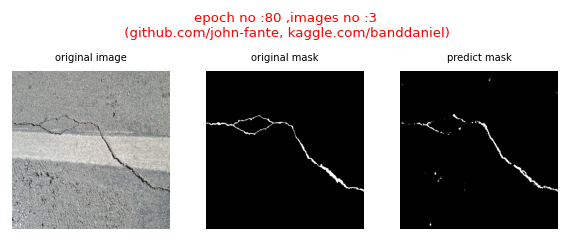

10/10 [==============================] - 18s 2s/step - loss: 0.0236 - dice_coef_loss: 0.4347 - dice_coef: 0.5653
Epoch 81/250
10/10 [==============================] - 12s 1s/step - loss: 0.0234 - dice_coef_loss: 0.4268 - dice_coef: 0.5732
Epoch 82/250
10/10 [==============================] - 14s 1s/step - loss: 0.0233 - dice_coef_loss: 0.4289 - dice_coef: 0.5711
Epoch 83/250
10/10 [==============================] - 12s 1s/step - loss: 0.0237 - dice_coef_loss: 0.4385 - dice_coef: 0.5615
Epoch 84/250
10/10 [==============================] - 14s 1s/step - loss: 0.0230 - dice_coef_loss: 0.4360 - dice_coef: 0.5640
Epoch 85/250
10/10 [==============================] - 13s 1s/step - loss: 0.0229 - dice_coef_loss: 0.4195 - dice_coef: 0.5805
Epoch 86/250
10/10 [==============================] - 13s 1s/step - loss: 0.0230 - dice_coef_loss: 0.4177 - dice_coef: 0.5823
Epoch 87/250
10/10 [==============================] - 15s 1s/step - loss: 0.0232 - dice_coef_loss: 0.4334 - dice_coef: 0.5666
Epoch

<Figure size 640x480 with 0 Axes>

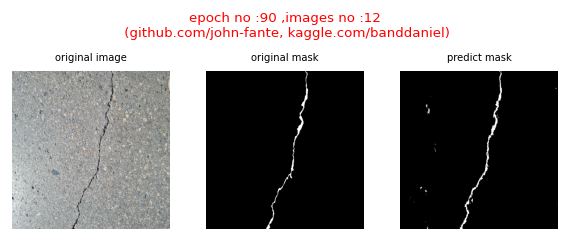

10/10 [==============================] - 73s 8s/step - loss: 0.0220 - dice_coef_loss: 0.4176 - dice_coef: 0.5824
Epoch 91/250
10/10 [==============================] - 16s 2s/step - loss: 0.0218 - dice_coef_loss: 0.4068 - dice_coef: 0.5932
Epoch 92/250
10/10 [==============================] - 12s 1s/step - loss: 0.0213 - dice_coef_loss: 0.3889 - dice_coef: 0.6111
Epoch 93/250
10/10 [==============================] - 12s 1s/step - loss: 0.0219 - dice_coef_loss: 0.4033 - dice_coef: 0.5967
Epoch 94/250
10/10 [==============================] - 13s 1s/step - loss: 0.0221 - dice_coef_loss: 0.4160 - dice_coef: 0.5840
Epoch 95/250
10/10 [==============================] - 14s 1s/step - loss: 0.0214 - dice_coef_loss: 0.4012 - dice_coef: 0.5988
Epoch 96/250
10/10 [==============================] - 13s 1s/step - loss: 0.0213 - dice_coef_loss: 0.3916 - dice_coef: 0.6084
Epoch 97/250
10/10 [==============================] - 12s 1s/step - loss: 0.0212 - dice_coef_loss: 0.4008 - dice_coef: 0.5992
Epoch

<Figure size 640x480 with 0 Axes>

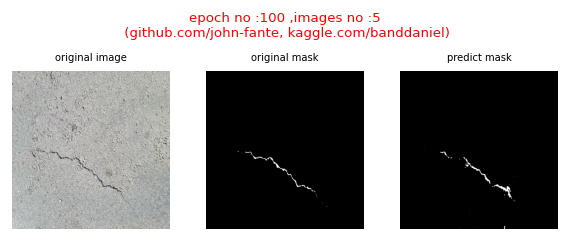

10/10 [==============================] - 17s 2s/step - loss: 0.0205 - dice_coef_loss: 0.3847 - dice_coef: 0.6153
Epoch 101/250
10/10 [==============================] - 13s 1s/step - loss: 0.0203 - dice_coef_loss: 0.3856 - dice_coef: 0.6144
Epoch 102/250
10/10 [==============================] - 13s 1s/step - loss: 0.0201 - dice_coef_loss: 0.3831 - dice_coef: 0.6169
Epoch 103/250
10/10 [==============================] - 13s 1s/step - loss: 0.0195 - dice_coef_loss: 0.3659 - dice_coef: 0.6341
Epoch 104/250
10/10 [==============================] - 12s 1s/step - loss: 0.0196 - dice_coef_loss: 0.3669 - dice_coef: 0.6331
Epoch 105/250
10/10 [==============================] - 12s 1s/step - loss: 0.0195 - dice_coef_loss: 0.3715 - dice_coef: 0.6285
Epoch 106/250
10/10 [==============================] - 14s 1s/step - loss: 0.0195 - dice_coef_loss: 0.3696 - dice_coef: 0.6304
Epoch 107/250
10/10 [==============================] - 12s 1s/step - loss: 0.0197 - dice_coef_loss: 0.3669 - dice_coef: 0.633

<Figure size 640x480 with 0 Axes>

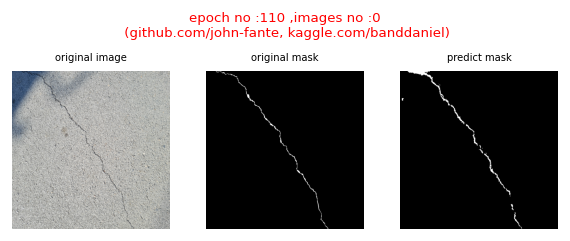

10/10 [==============================] - 17s 2s/step - loss: 0.0193 - dice_coef_loss: 0.3672 - dice_coef: 0.6328
Epoch 111/250
10/10 [==============================] - 12s 1s/step - loss: 0.0189 - dice_coef_loss: 0.3541 - dice_coef: 0.6459
Epoch 112/250
10/10 [==============================] - 15s 1s/step - loss: 0.0189 - dice_coef_loss: 0.3584 - dice_coef: 0.6416
Epoch 113/250
10/10 [==============================] - 13s 1s/step - loss: 0.0187 - dice_coef_loss: 0.3543 - dice_coef: 0.6457
Epoch 114/250
10/10 [==============================] - 13s 1s/step - loss: 0.0185 - dice_coef_loss: 0.3514 - dice_coef: 0.6486
Epoch 115/250
10/10 [==============================] - 12s 1s/step - loss: 0.0180 - dice_coef_loss: 0.3401 - dice_coef: 0.6599
Epoch 116/250
10/10 [==============================] - 13s 1s/step - loss: 0.0178 - dice_coef_loss: 0.3454 - dice_coef: 0.6546
Epoch 117/250
10/10 [==============================] - 13s 1s/step - loss: 0.0176 - dice_coef_loss: 0.3423 - dice_coef: 0.657

<Figure size 640x480 with 0 Axes>

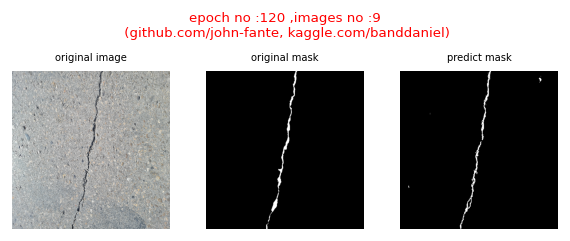

10/10 [==============================] - 16s 2s/step - loss: 0.0185 - dice_coef_loss: 0.3514 - dice_coef: 0.6486
Epoch 121/250
10/10 [==============================] - 12s 1s/step - loss: 0.0187 - dice_coef_loss: 0.3731 - dice_coef: 0.6269
Epoch 122/250
10/10 [==============================] - 12s 1s/step - loss: 0.0183 - dice_coef_loss: 0.3434 - dice_coef: 0.6566
Epoch 123/250
10/10 [==============================] - 12s 1s/step - loss: 0.0181 - dice_coef_loss: 0.3531 - dice_coef: 0.6469
Epoch 124/250
10/10 [==============================] - 15s 1s/step - loss: 0.0178 - dice_coef_loss: 0.3451 - dice_coef: 0.6549
Epoch 125/250
10/10 [==============================] - 11s 1s/step - loss: 0.0174 - dice_coef_loss: 0.3331 - dice_coef: 0.6669
Epoch 126/250
10/10 [==============================] - 13s 1s/step - loss: 0.0169 - dice_coef_loss: 0.3291 - dice_coef: 0.6709
Epoch 127/250
10/10 [==============================] - 12s 1s/step - loss: 0.0171 - dice_coef_loss: 0.3270 - dice_coef: 0.673

<Figure size 640x480 with 0 Axes>

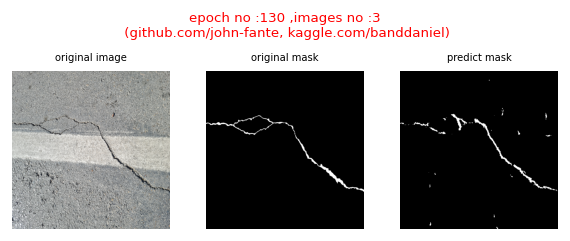

10/10 [==============================] - 18s 2s/step - loss: 0.0164 - dice_coef_loss: 0.3172 - dice_coef: 0.6828
Epoch 131/250
10/10 [==============================] - 13s 1s/step - loss: 0.0169 - dice_coef_loss: 0.3310 - dice_coef: 0.6690
Epoch 132/250
10/10 [==============================] - 14s 1s/step - loss: 0.0167 - dice_coef_loss: 0.3254 - dice_coef: 0.6746
Epoch 133/250
10/10 [==============================] - 12s 1s/step - loss: 0.0161 - dice_coef_loss: 0.3224 - dice_coef: 0.6776
Epoch 134/250
10/10 [==============================] - 16s 2s/step - loss: 0.0159 - dice_coef_loss: 0.3131 - dice_coef: 0.6869
Epoch 135/250
10/10 [==============================] - 13s 1s/step - loss: 0.0154 - dice_coef_loss: 0.3072 - dice_coef: 0.6928
Epoch 136/250
10/10 [==============================] - 13s 1s/step - loss: 0.0150 - dice_coef_loss: 0.3037 - dice_coef: 0.6963
Epoch 137/250
10/10 [==============================] - 12s 1s/step - loss: 0.0158 - dice_coef_loss: 0.3160 - dice_coef: 0.684

<Figure size 640x480 with 0 Axes>

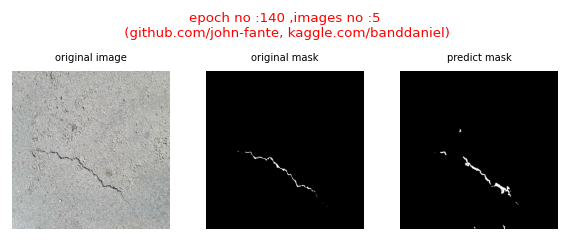

10/10 [==============================] - 17s 2s/step - loss: 0.0148 - dice_coef_loss: 0.3030 - dice_coef: 0.6970
Epoch 141/250
10/10 [==============================] - 13s 1s/step - loss: 0.0150 - dice_coef_loss: 0.3117 - dice_coef: 0.6883
Epoch 142/250
10/10 [==============================] - 13s 1s/step - loss: 0.0151 - dice_coef_loss: 0.2963 - dice_coef: 0.7037
Epoch 143/250
10/10 [==============================] - 12s 1s/step - loss: 0.0145 - dice_coef_loss: 0.3011 - dice_coef: 0.6989
Epoch 144/250
10/10 [==============================] - 15s 1s/step - loss: 0.0142 - dice_coef_loss: 0.2890 - dice_coef: 0.7110
Epoch 145/250
10/10 [==============================] - 13s 1s/step - loss: 0.0133 - dice_coef_loss: 0.2761 - dice_coef: 0.7239
Epoch 146/250
10/10 [==============================] - 15s 1s/step - loss: 0.0132 - dice_coef_loss: 0.2691 - dice_coef: 0.7309
Epoch 147/250
10/10 [==============================] - 13s 1s/step - loss: 0.0139 - dice_coef_loss: 0.2879 - dice_coef: 0.712

<Figure size 640x480 with 0 Axes>

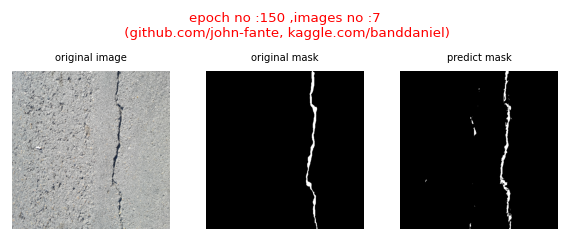

10/10 [==============================] - 17s 2s/step - loss: 0.0140 - dice_coef_loss: 0.2909 - dice_coef: 0.7091
Epoch 151/250
10/10 [==============================] - 12s 1s/step - loss: 0.0138 - dice_coef_loss: 0.2831 - dice_coef: 0.7169
Epoch 152/250
10/10 [==============================] - 12s 1s/step - loss: 0.0133 - dice_coef_loss: 0.2718 - dice_coef: 0.7282
Epoch 153/250
10/10 [==============================] - 12s 1s/step - loss: 0.0134 - dice_coef_loss: 0.2772 - dice_coef: 0.7228
Epoch 154/250
10/10 [==============================] - 14s 1s/step - loss: 0.0135 - dice_coef_loss: 0.2761 - dice_coef: 0.7239
Epoch 155/250
10/10 [==============================] - 14s 1s/step - loss: 0.0132 - dice_coef_loss: 0.2753 - dice_coef: 0.7247
Epoch 156/250
10/10 [==============================] - 14s 1s/step - loss: 0.0134 - dice_coef_loss: 0.2679 - dice_coef: 0.7321
Epoch 157/250
10/10 [==============================] - 12s 1s/step - loss: 0.0126 - dice_coef_loss: 0.2618 - dice_coef: 0.738

<Figure size 640x480 with 0 Axes>

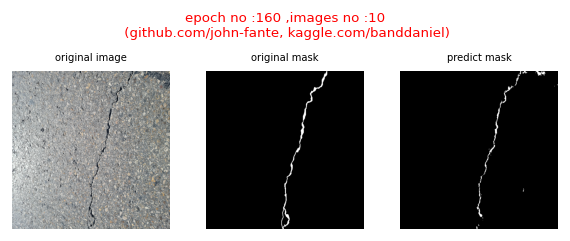

10/10 [==============================] - 18s 2s/step - loss: 0.0127 - dice_coef_loss: 0.2579 - dice_coef: 0.7421
Epoch 161/250
10/10 [==============================] - 12s 1s/step - loss: 0.0122 - dice_coef_loss: 0.2646 - dice_coef: 0.7354
Epoch 162/250
10/10 [==============================] - 12s 1s/step - loss: 0.0130 - dice_coef_loss: 0.2701 - dice_coef: 0.7299
Epoch 163/250
10/10 [==============================] - 13s 1s/step - loss: 0.0121 - dice_coef_loss: 0.2544 - dice_coef: 0.7456
Epoch 164/250
10/10 [==============================] - 13s 1s/step - loss: 0.0130 - dice_coef_loss: 0.2674 - dice_coef: 0.7326
Epoch 165/250
10/10 [==============================] - 14s 1s/step - loss: 0.0124 - dice_coef_loss: 0.2596 - dice_coef: 0.7404
Epoch 166/250
10/10 [==============================] - 15s 1s/step - loss: 0.0118 - dice_coef_loss: 0.2502 - dice_coef: 0.7498
Epoch 167/250
10/10 [==============================] - 12s 1s/step - loss: 0.0115 - dice_coef_loss: 0.2464 - dice_coef: 0.753

<Figure size 640x480 with 0 Axes>

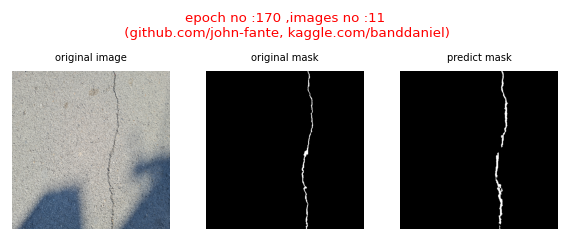

10/10 [==============================] - 18s 2s/step - loss: 0.0108 - dice_coef_loss: 0.2337 - dice_coef: 0.7663
Epoch 171/250
10/10 [==============================] - 12s 1s/step - loss: 0.0108 - dice_coef_loss: 0.2319 - dice_coef: 0.7681
Epoch 172/250
10/10 [==============================] - 12s 1s/step - loss: 0.0109 - dice_coef_loss: 0.2303 - dice_coef: 0.7697
Epoch 173/250
10/10 [==============================] - 12s 1s/step - loss: 0.0109 - dice_coef_loss: 0.2326 - dice_coef: 0.7674
Epoch 174/250
10/10 [==============================] - 13s 1s/step - loss: 0.0116 - dice_coef_loss: 0.2396 - dice_coef: 0.7604
Epoch 175/250
10/10 [==============================] - 14s 1s/step - loss: 0.0118 - dice_coef_loss: 0.2557 - dice_coef: 0.7443
Epoch 176/250
10/10 [==============================] - 15s 1s/step - loss: 0.0112 - dice_coef_loss: 0.2391 - dice_coef: 0.7609
Epoch 177/250
10/10 [==============================] - 12s 1s/step - loss: 0.0105 - dice_coef_loss: 0.2259 - dice_coef: 0.774

<Figure size 640x480 with 0 Axes>

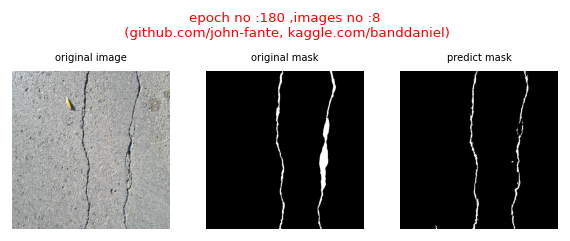

10/10 [==============================] - 15s 1s/step - loss: 0.0097 - dice_coef_loss: 0.2103 - dice_coef: 0.7897
Epoch 181/250
10/10 [==============================] - 15s 1s/step - loss: 0.0104 - dice_coef_loss: 0.2227 - dice_coef: 0.7773
Epoch 182/250
10/10 [==============================] - 13s 1s/step - loss: 0.0102 - dice_coef_loss: 0.2278 - dice_coef: 0.7722
Epoch 183/250
10/10 [==============================] - 15s 1s/step - loss: 0.0108 - dice_coef_loss: 0.2331 - dice_coef: 0.7669
Epoch 184/250
10/10 [==============================] - 13s 1s/step - loss: 0.0104 - dice_coef_loss: 0.2322 - dice_coef: 0.7678
Epoch 185/250
10/10 [==============================] - 14s 1s/step - loss: 0.0100 - dice_coef_loss: 0.2136 - dice_coef: 0.7864
Epoch 186/250
10/10 [==============================] - 12s 1s/step - loss: 0.0099 - dice_coef_loss: 0.2210 - dice_coef: 0.7790
Epoch 187/250
10/10 [==============================] - 13s 1s/step - loss: 0.0103 - dice_coef_loss: 0.2236 - dice_coef: 0.776

<Figure size 640x480 with 0 Axes>

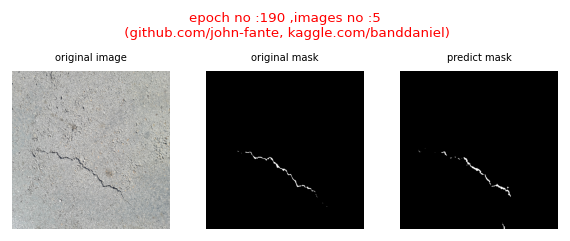

10/10 [==============================] - 15s 1s/step - loss: 0.0095 - dice_coef_loss: 0.2088 - dice_coef: 0.7912
Epoch 191/250
10/10 [==============================] - 14s 1s/step - loss: 0.0091 - dice_coef_loss: 0.2007 - dice_coef: 0.7993
Epoch 192/250
10/10 [==============================] - 12s 1s/step - loss: 0.0091 - dice_coef_loss: 0.1968 - dice_coef: 0.8032
Epoch 193/250
10/10 [==============================] - 15s 1s/step - loss: 0.0091 - dice_coef_loss: 0.2045 - dice_coef: 0.7955
Epoch 194/250
10/10 [==============================] - 13s 1s/step - loss: 0.0092 - dice_coef_loss: 0.2013 - dice_coef: 0.7987
Epoch 195/250
10/10 [==============================] - 15s 1s/step - loss: 0.0092 - dice_coef_loss: 0.2002 - dice_coef: 0.7998
Epoch 196/250
10/10 [==============================] - 12s 1s/step - loss: 0.0092 - dice_coef_loss: 0.2071 - dice_coef: 0.7929
Epoch 197/250
10/10 [==============================] - 12s 1s/step - loss: 0.0090 - dice_coef_loss: 0.2011 - dice_coef: 0.798

<Figure size 640x480 with 0 Axes>

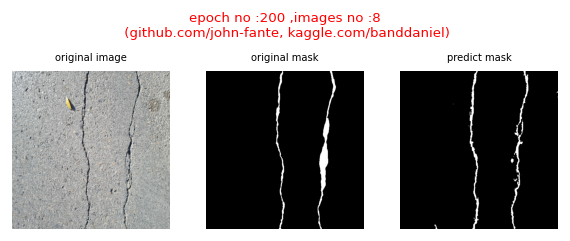

10/10 [==============================] - 18s 2s/step - loss: 0.0092 - dice_coef_loss: 0.2071 - dice_coef: 0.7929
Epoch 201/250
10/10 [==============================] - 12s 1s/step - loss: 0.0095 - dice_coef_loss: 0.2016 - dice_coef: 0.7984
Epoch 202/250
10/10 [==============================] - 13s 1s/step - loss: 0.0091 - dice_coef_loss: 0.2062 - dice_coef: 0.7938
Epoch 203/250
10/10 [==============================] - 12s 1s/step - loss: 0.0087 - dice_coef_loss: 0.1923 - dice_coef: 0.8077
Epoch 204/250
10/10 [==============================] - 15s 1s/step - loss: 0.0091 - dice_coef_loss: 0.1971 - dice_coef: 0.8029
Epoch 205/250
10/10 [==============================] - 13s 1s/step - loss: 0.0087 - dice_coef_loss: 0.1878 - dice_coef: 0.8122
Epoch 206/250
10/10 [==============================] - 12s 1s/step - loss: 0.0092 - dice_coef_loss: 0.2067 - dice_coef: 0.7933
Epoch 207/250
10/10 [==============================] - 13s 1s/step - loss: 0.0089 - dice_coef_loss: 0.1970 - dice_coef: 0.803

<Figure size 640x480 with 0 Axes>

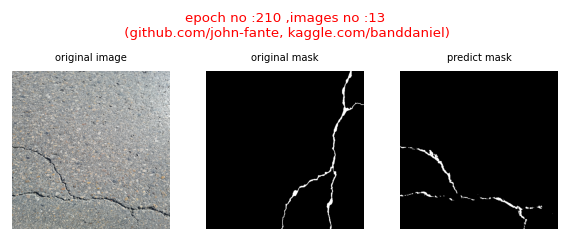

10/10 [==============================] - 15s 1s/step - loss: 0.0092 - dice_coef_loss: 0.2074 - dice_coef: 0.7926
Epoch 211/250
10/10 [==============================] - 15s 1s/step - loss: 0.0086 - dice_coef_loss: 0.1897 - dice_coef: 0.8103
Epoch 212/250
10/10 [==============================] - 12s 1s/step - loss: 0.0089 - dice_coef_loss: 0.1926 - dice_coef: 0.8074
Epoch 213/250
10/10 [==============================] - 13s 1s/step - loss: 0.0091 - dice_coef_loss: 0.1974 - dice_coef: 0.8026
Epoch 214/250
10/10 [==============================] - 13s 1s/step - loss: 0.0086 - dice_coef_loss: 0.1926 - dice_coef: 0.8074
Epoch 215/250
10/10 [==============================] - 12s 1s/step - loss: 0.0079 - dice_coef_loss: 0.1728 - dice_coef: 0.8272
Epoch 216/250
10/10 [==============================] - 14s 1s/step - loss: 0.0079 - dice_coef_loss: 0.1778 - dice_coef: 0.8222
Epoch 217/250
10/10 [==============================] - 13s 1s/step - loss: 0.0077 - dice_coef_loss: 0.1742 - dice_coef: 0.825

<Figure size 640x480 with 0 Axes>

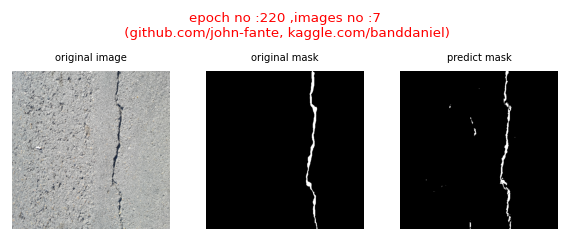

10/10 [==============================] - 15s 1s/step - loss: 0.0075 - dice_coef_loss: 0.1652 - dice_coef: 0.8348
Epoch 221/250
10/10 [==============================] - 14s 1s/step - loss: 0.0073 - dice_coef_loss: 0.1665 - dice_coef: 0.8335
Epoch 222/250
10/10 [==============================] - 14s 1s/step - loss: 0.0077 - dice_coef_loss: 0.1752 - dice_coef: 0.8248
Epoch 223/250
10/10 [==============================] - 14s 1s/step - loss: 0.0074 - dice_coef_loss: 0.1674 - dice_coef: 0.8326
Epoch 224/250
10/10 [==============================] - 11s 1s/step - loss: 0.0077 - dice_coef_loss: 0.1687 - dice_coef: 0.8313
Epoch 225/250
10/10 [==============================] - 13s 1s/step - loss: 0.0074 - dice_coef_loss: 0.1718 - dice_coef: 0.8282
Epoch 226/250
10/10 [==============================] - 14s 1s/step - loss: 0.0078 - dice_coef_loss: 0.1744 - dice_coef: 0.8256
Epoch 227/250
10/10 [==============================] - 12s 1s/step - loss: 0.0074 - dice_coef_loss: 0.1651 - dice_coef: 0.834

<Figure size 640x480 with 0 Axes>

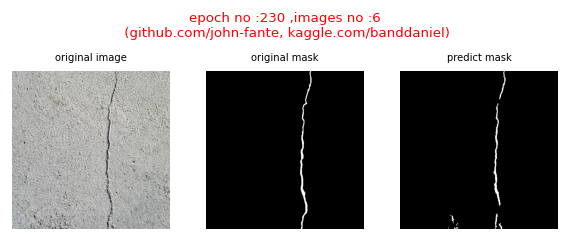

10/10 [==============================] - 17s 2s/step - loss: 0.0084 - dice_coef_loss: 0.1878 - dice_coef: 0.8122
Epoch 231/250
10/10 [==============================] - 14s 1s/step - loss: 0.0077 - dice_coef_loss: 0.1670 - dice_coef: 0.8330
Epoch 232/250
10/10 [==============================] - 12s 1s/step - loss: 0.0078 - dice_coef_loss: 0.1738 - dice_coef: 0.8262
Epoch 233/250
10/10 [==============================] - 15s 1s/step - loss: 0.0078 - dice_coef_loss: 0.1698 - dice_coef: 0.8302
Epoch 234/250
10/10 [==============================] - 13s 1s/step - loss: 0.0074 - dice_coef_loss: 0.1691 - dice_coef: 0.8309
Epoch 235/250
10/10 [==============================] - 14s 1s/step - loss: 0.0078 - dice_coef_loss: 0.1732 - dice_coef: 0.8268
Epoch 236/250
10/10 [==============================] - 13s 1s/step - loss: 0.0075 - dice_coef_loss: 0.1679 - dice_coef: 0.8321
Epoch 237/250
10/10 [==============================] - 13s 1s/step - loss: 0.0073 - dice_coef_loss: 0.1630 - dice_coef: 0.837

<Figure size 640x480 with 0 Axes>

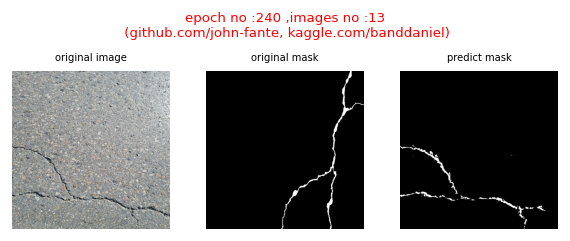

10/10 [==============================] - 18s 2s/step - loss: 0.0068 - dice_coef_loss: 0.1531 - dice_coef: 0.8469
Epoch 241/250
10/10 [==============================] - 12s 1s/step - loss: 0.0067 - dice_coef_loss: 0.1533 - dice_coef: 0.8467
Epoch 242/250
10/10 [==============================] - 14s 1s/step - loss: 0.0069 - dice_coef_loss: 0.1557 - dice_coef: 0.8443
Epoch 243/250
10/10 [==============================] - 12s 1s/step - loss: 0.0067 - dice_coef_loss: 0.1524 - dice_coef: 0.8476
Epoch 244/250
10/10 [==============================] - 14s 1s/step - loss: 0.0068 - dice_coef_loss: 0.1520 - dice_coef: 0.8480
Epoch 245/250
10/10 [==============================] - 11s 1s/step - loss: 0.0069 - dice_coef_loss: 0.1575 - dice_coef: 0.8425
Epoch 246/250
10/10 [==============================] - 15s 1s/step - loss: 0.0072 - dice_coef_loss: 0.1619 - dice_coef: 0.8381
Epoch 247/250
10/10 [==============================] - 12s 1s/step - loss: 0.0068 - dice_coef_loss: 0.1561 - dice_coef: 0.843

<Figure size 640x480 with 0 Axes>

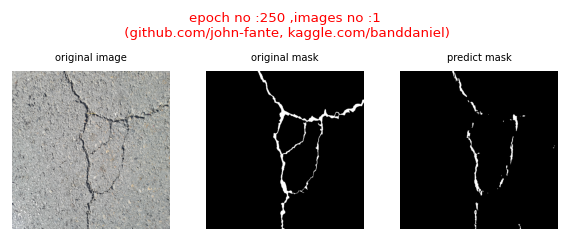

10/10 [==============================] - 17s 2s/step - loss: 0.0066 - dice_coef_loss: 0.1519 - dice_coef: 0.8481


<Figure size 640x480 with 0 Axes>

In [189]:
hist = model.fit(train_dataset, batch_size= BATCH_SIZE, epochs = 250 , callbacks = my_callbacks)

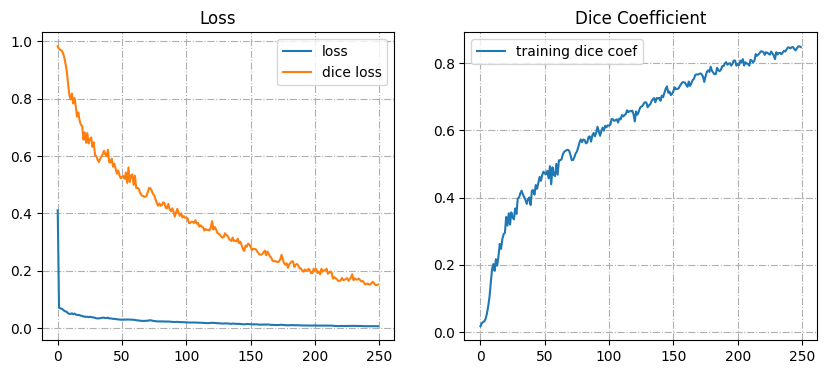

In [208]:
fig, axs = plt.subplots(1,2, figsize = (10,4), dpi = 100)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['dice_coef_loss'])
axs[0].legend(["loss", "dice loss"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Dice Coefficient")
axs[1].plot(hist.history['dice_coef'])
axs[1].legend(["training dice coef"])

In [190]:
test_eval = model.evaluate(test_dataset)

print('Test Dice Loss : {0:.4f}'.format(test_eval[1]))
print('Test Dice Coefficient : {0:.4f}'.format(test_eval[2]))

2/2 [==============================] - 4s 1s/step - loss: 0.0719 - dice_coef_loss: 0.4754 - dice_coef: 0.5246
Test Dice Loss : 0.4754
Test Dice Coefficient : 0.5246


In [194]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)

y_test_take = []
for x in range(len(test_take1_)):
    y_test_take.extend(test_take1_[x][1].numpy())

pred_ = np.squeeze(pred)

threshold_1  = 0.5 #threshold for prediction
bitmap_pred_1 = (pred_ > threshold_1).astype(np.uint8)

threshold_2  = 0.7 #threshold for prediction
bitmap_pred_2 = (pred_ > threshold_2).astype(np.uint8)

2/2 [==============================] - 2s 864ms/step


In [195]:
# A function that creating one random image in the test set and prediction it

def random_test_sample_with_prediction():
    idxs = np.random.permutation(len(y_test_take))[:3]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs



    fig, axs = plt.subplots(3,4, figsize = (10, 10 ) ,dpi = 150)

    for i in range(3):
        image = test_take1_[batch_idx[i]][0][image_idx[i]]
        mask = test_take1_[batch_idx[i]][1][image_idx[i]]
        pred_mask_1 = bitmap_pred_1[idx[i]]
        pred_mask_2 = bitmap_pred_2[idx[i]]



        axs[i][0].imshow(image)
        axs[i][0].axis('off')
        axs[i][0].set_title('original image (no: ' + str(idxs[i]) + ")", fontsize = 5)

        axs[i][1].imshow(mask, cmap = 'gray')
        axs[i][1].axis('off')
        axs[i][1].set_title('original mask', fontsize = 5)

        axs[i][2].imshow(pred_mask_1 , cmap = 'gray')
        axs[i][2].axis('off')
        axs[i][2].set_title('pred mask (0.5 threshold)', fontsize = 5)

        axs[i][3].imshow(pred_mask_2 , cmap = 'gray')
        axs[i][3].axis('off')
        axs[i][3].set_title('pred mask (0.7 threshold)', fontsize = 5)



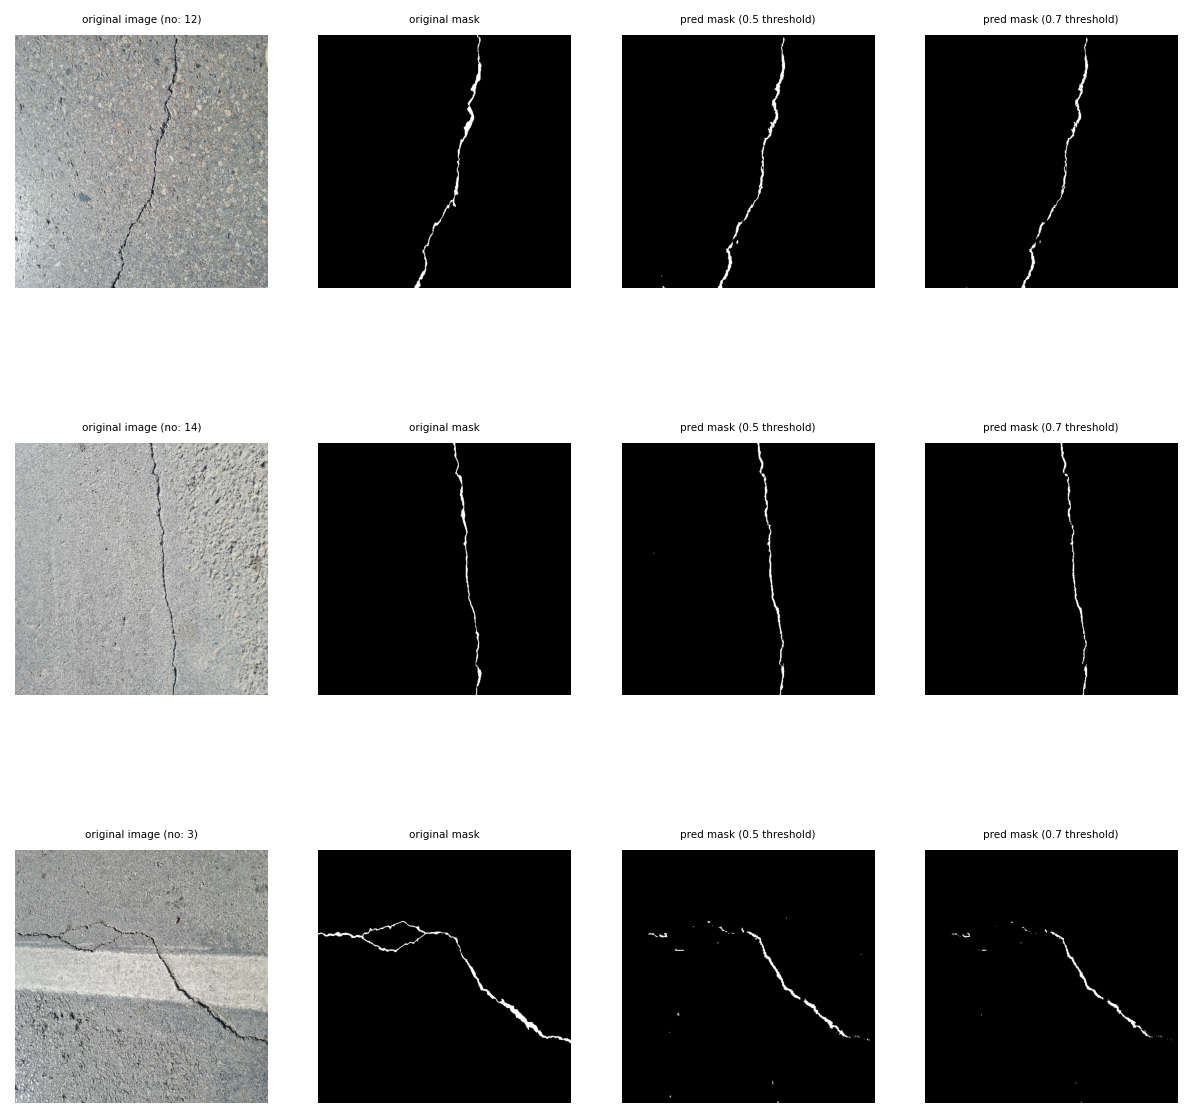

In [197]:
random_test_sample_with_prediction()